# 1. Problem Description & Motivation

Most robots are composed of 3 main parts:
- The Controller ‐ also known as the "brain" which is run by a computer program.
- Mechanical parts ‐ motors, pistons, grippers, wheels, and gears that make the robot move, grab, turn, and lift.
- Sensors ‐ to tell the robot about its surroundings.

For a robot to learn and carry out a task correctly, it needs to rely and integrate all 3 components effectively.
In our problem, we help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).
*IMU sensor data* is collected while driving a small mobile robot over *different floor surfaces* on the university premises. The task is to **predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity**.

## What is IMU?
IMU stands for Inertial Measurement Unit, which is an electronic device that measures and reports a body's specific force, angular rate, and sometimes the magnetic field surroundings the body, using a combination of [accelerometers](https://en.wikipedia.org/wiki/Accelerometer) and [gyroscopes](https://en.wikipedia.org/wiki/Gyroscope),  sometimes also [magnetometers](https://en.wikipedia.org/wiki/Magnetometers). With these 3 incorporated sensors, the IMU measures at least 3 different types of quantities:
1. 3D Orientation
2. Linear Acceleration
3. Angular Acceleration

# 2. Data Acquisition

The dataset that we will be using comes a [Kaggle Competition](https://www.kaggle.com/c/career-con-2019/data).
X_train/test.csv = the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns
- row_id: The ID for this row.

- series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

- measurement_number: Measurement number within the series.

y_train.csv = the surfaces for training set.

- series_id: ID number for the measurement series.

- group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

- surface: the target for this competition.

# 3. Data Exploration
In this stage, we will explore the data to gain preliminary insights and also ensure our data is error-free, e.g. no missing entries or incorrect format. We use Pandas & other visualisation tools to summarise the main characteristics of the provided dataset.

In [75]:
# Install necessary packages
# windows command
!py -m pip install tabulate 
# pls use below for Unix OSes (Mac, Linux distros)
# !pip install tabulate

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [123]:
#%matplotlib notebook
%matplotlib inline

#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.signal import welch
from IPython.display import display, HTML

#Import all data and labels
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')

print('X_train has {} rows, {} columns.'.format(X_train.shape[0],X_train.shape[1]))
print('y_train has {} rows, {} columns.'.format(y_train.shape[0],y_train.shape[1]))
print('X_test has {} rows, {} columns.'.format(X_test.shape[0],X_test.shape[1]))

X_train has 487680 rows, 13 columns.
y_train has 3810 rows, 3 columns.
X_test has 488448 rows, 13 columns.


It seems that number of rows for X_train is different from y_train. Let us print out X_train & y_train data in tabular format.

## Visualise tabular data

In [72]:
disp_range = np.r_[0:3,125:132,253:260] # selects discontinuous subsets
display(HTML(X_train.loc[disp_range,:].to_html()))
display(HTML(y_train.head().to_html()))

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.748570,2.10300,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003385,0.339950,1.50640,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.264290,1.59220,-8.7267
125,0_125,0,125,-0.75949,-0.63309,-0.104670,-0.106900,-0.083083,-0.044480,0.031726,-0.981930,0.97328,-9.9795
126,0_126,0,126,-0.75950,-0.63307,-0.104640,-0.106930,-0.001305,-0.031012,0.017241,-0.725910,0.34931,-11.9770
127,0_127,0,127,-0.75953,-0.63306,-0.104610,-0.106840,0.073856,0.020353,0.018466,-0.534260,0.80346,-10.6970
128,1_0,1,0,-0.95896,0.24074,0.030758,-0.146610,0.283420,0.002192,-0.050810,2.184800,2.25260,-8.9503
129,1_1,1,1,-0.95890,0.24079,0.030786,-0.146930,0.108930,-0.009485,0.009155,0.499050,2.97620,-5.4953
130,1_2,1,2,-0.95889,0.24076,0.030807,-0.147020,-0.073197,0.003959,-0.023384,0.748270,1.68030,-7.3061
131,1_3,1,3,-0.95888,0.24076,0.030742,-0.147120,-0.064979,0.068265,0.018673,1.840800,0.22349,-11.4910


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


Each row in X_train corresponds to 1 data point and series id. From above, we see that each series contains 128 data points. Hence each label corresponds to a series id.

## Summary Statistics for each feature

In [50]:
orientation_keys = X_train.keys()[3:7]
angVel_keys = X_train.keys()[7:10]
linAcc_keys = X_train.keys()[10:13]
keys = [orientation_keys,angVel_keys,linAcc_keys]

for subKeys in keys:
    print('Summary Statistics for {}'.format(subKeys))
    stats = pd.DataFrame(X_train[subKeys].describe())
    print(tabulate(stats,headers=['Statistic']+list(subKeys),tablefmt='psql',numalign='right'))


print(tabulate(y_train.describe(),headers='keys',tablefmt='psql',numalign='right')) ## why not printing out label col??

Summary Statistics for Index(['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W'], dtype='object')
+-------------+-----------------+-----------------+-----------------+-----------------+
| Statistic   |   orientation_X |   orientation_Y |   orientation_Z |   orientation_W |
|-------------+-----------------+-----------------+-----------------+-----------------|
| count       |          487680 |          487680 |          487680 |          487680 |
| mean        |      -0.0180497 |        0.075062 |       0.0124577 |     -0.00380374 |
| std         |        0.685696 |        0.708226 |        0.105972 |        0.104299 |
| min         |         -0.9891 |        -0.98965 |        -0.16283 |        -0.15662 |
| 25%         |        -0.70512 |        -0.68898 |      -0.0894662 |        -0.10606 |
| 50%         |        -0.10596 |        0.237855 |       0.0319495 |      -0.0187045 |
| 75%         |        0.651803 |         0.80955 |         0.12287 |       0.0972153 |
| max

## Class distribution

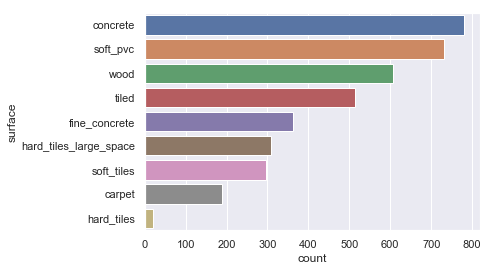

In [144]:
y_labels = list(y_train['surface'].value_counts().index)
sns.set(style='darkgrid')
sns.countplot(y = 'surface',
              data = y_train,
              order = y_labels)

## Duplicate & Missing data
Check for missing or repeated data/labels: 0 missing data, 0 duplicated data

In [141]:
print('# X_train missing data')
print(X_train.isnull().sum())

print('\n# X_test missing data')
print(X_test.isnull().sum())

print('\n# y_train missing data')
print(y_train.isnull().sum())

print('\n# of duplicate entries for X_train:',list(X_train.duplicated()).count('True'))
print('# of duplicate entries for X_test:',list(X_test.duplicated()).count('True'))
print('# of duplicate entries for y_train:',list(y_train.duplicated()).count('True'))


# X_train missing data
row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

# X_test missing data
row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64

# y_train missing data
series_id    0
group_id     0
surface      0
dtype: int64

# of duplicate entries for X_train: 0
# of duplicate entries for X_test: 0
# of duplicate entries for y_train: 0


## Rearrange data into series format
Sort and ensure data is in sampled order (measurement_number and series_id)
Store time series data in 3D array(series_id, time order, features)

In [143]:
X_train_sorted = X_train.sort_values(by = ['series_id', 'measurement_number'])
y_train_sorted = y_train.sort_values(by = ['series_id', 'group_id'])
X_train_sorted.head()
y_train_sorted.head()
col = X_train.columns.values #stores the feature names

In [111]:
a = np.zeros(((X_train.shape[0]//128),128,10)) #create 3D array [series_id][time_order][feature]
for j in range(a.shape[2]):
    for i in range(a.shape[0]):
        a[i,:,j]=X_train_sorted.ix[i*128:128*(i+1)-1, col[3+j]]

# Normalising so we can overlay and visualise the data
for j in range(a.shape[2]):
    for i in range(a.shape[0]):
        a[i,:,j]= (a[i,:,j]-np.mean(a[i,:,j]))/np.std(a[i,:,j])

C:\Users\pohyk\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


## Plot time-domain normalised values for each feature
By doing so, we can see the time-domain variations and patterns of each feature, for various classes.

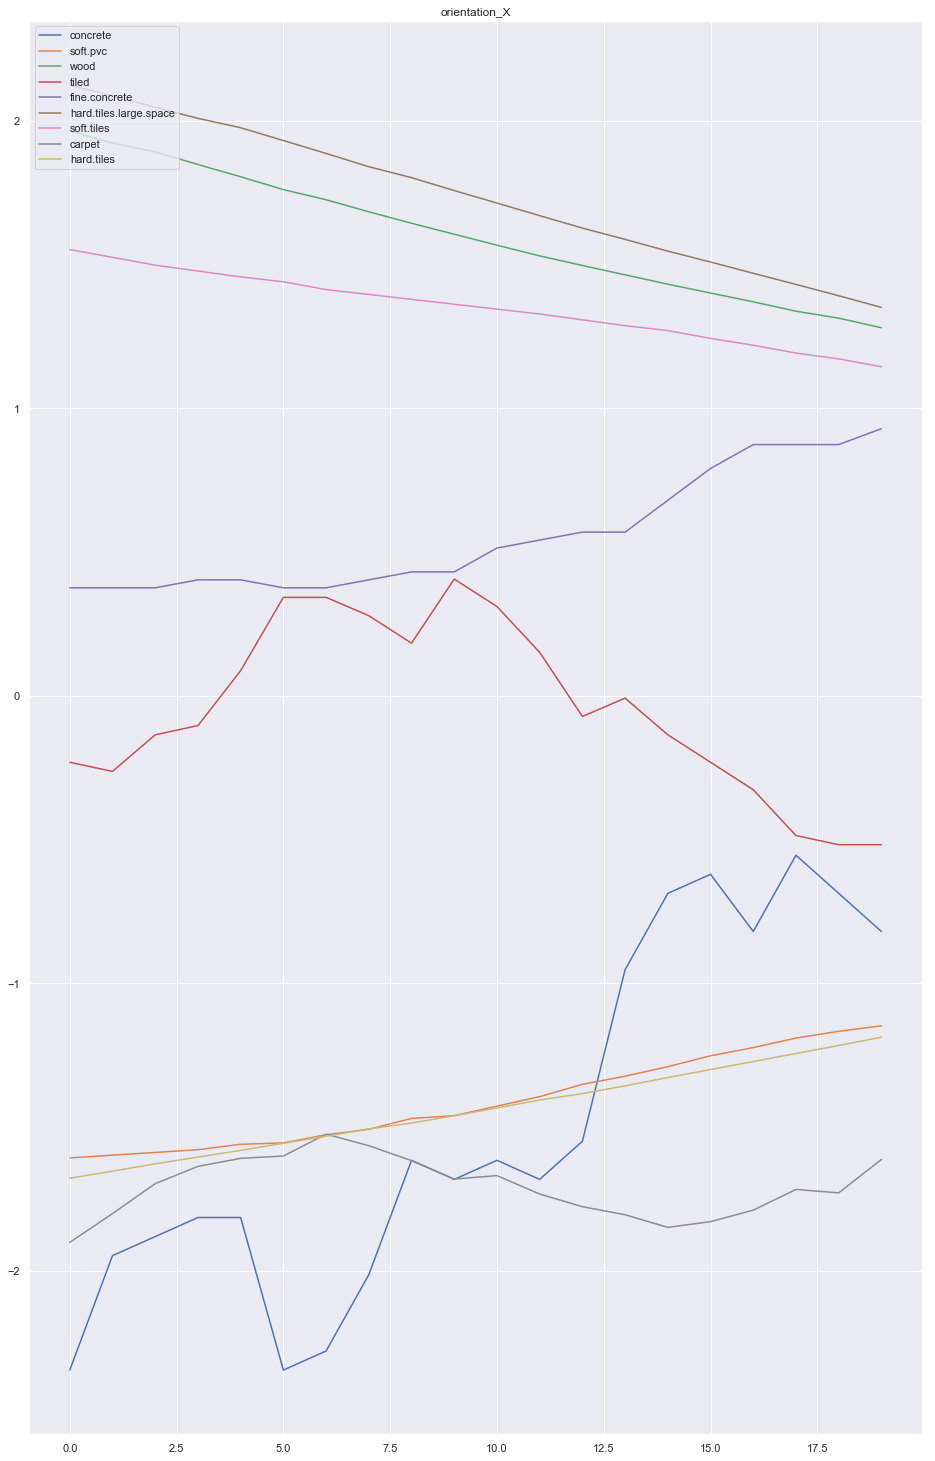

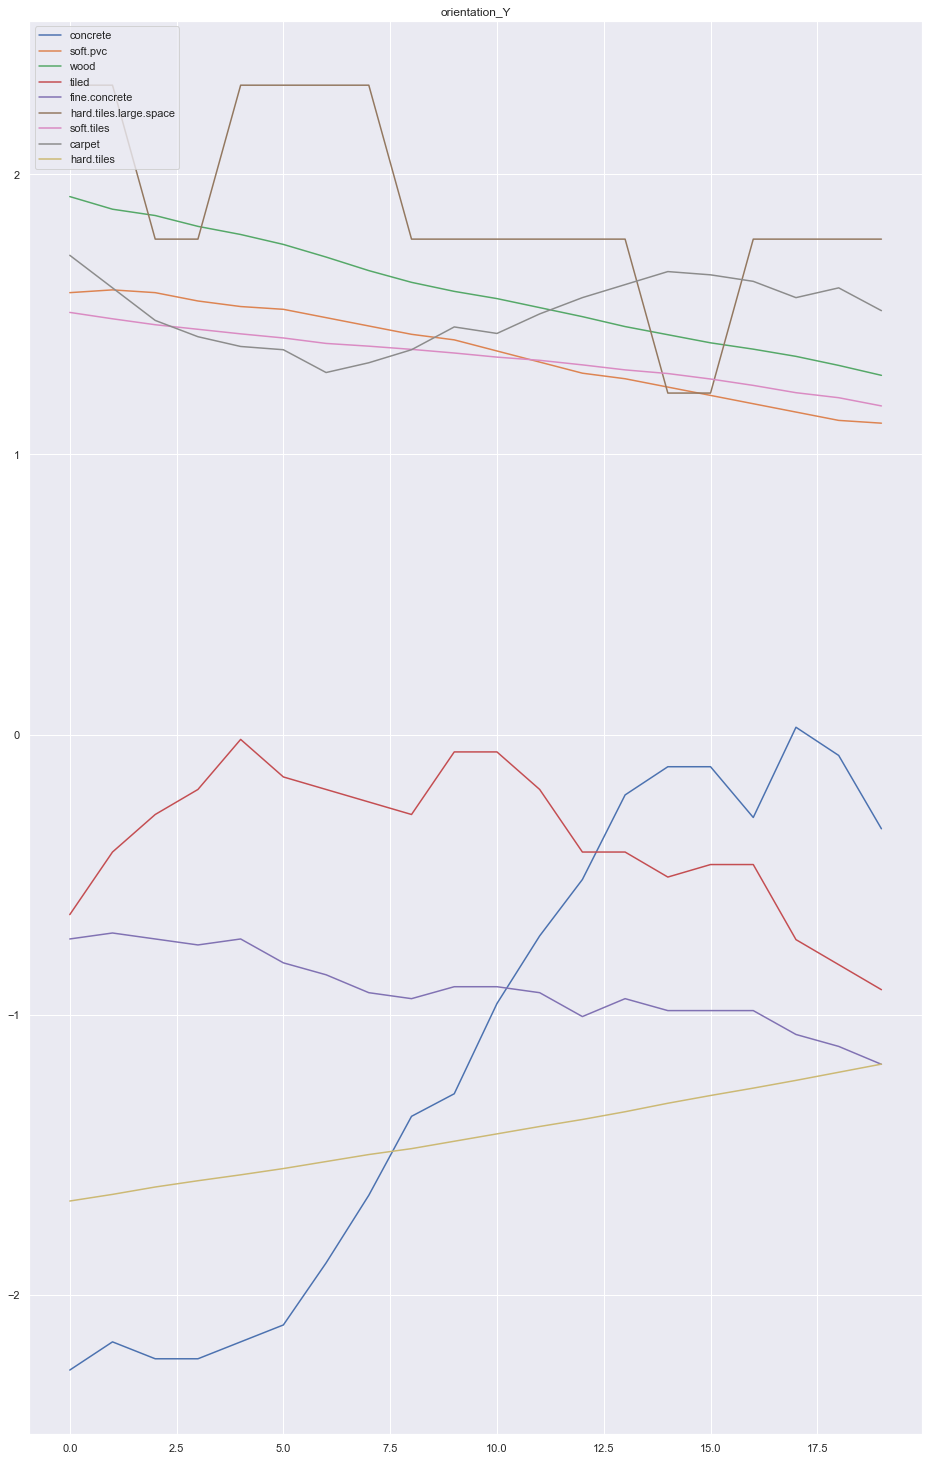

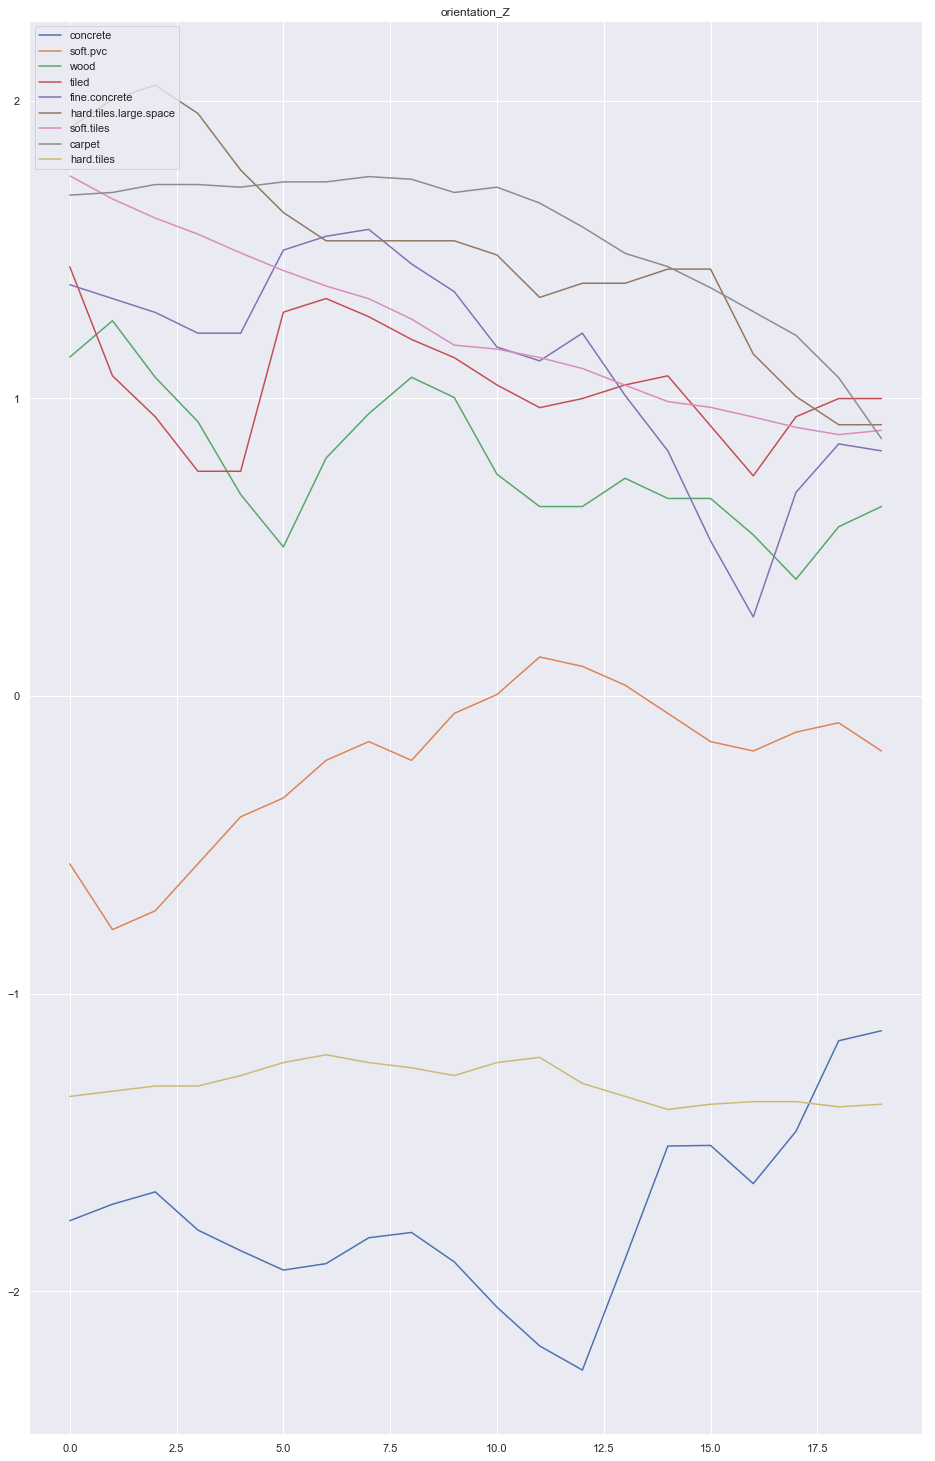

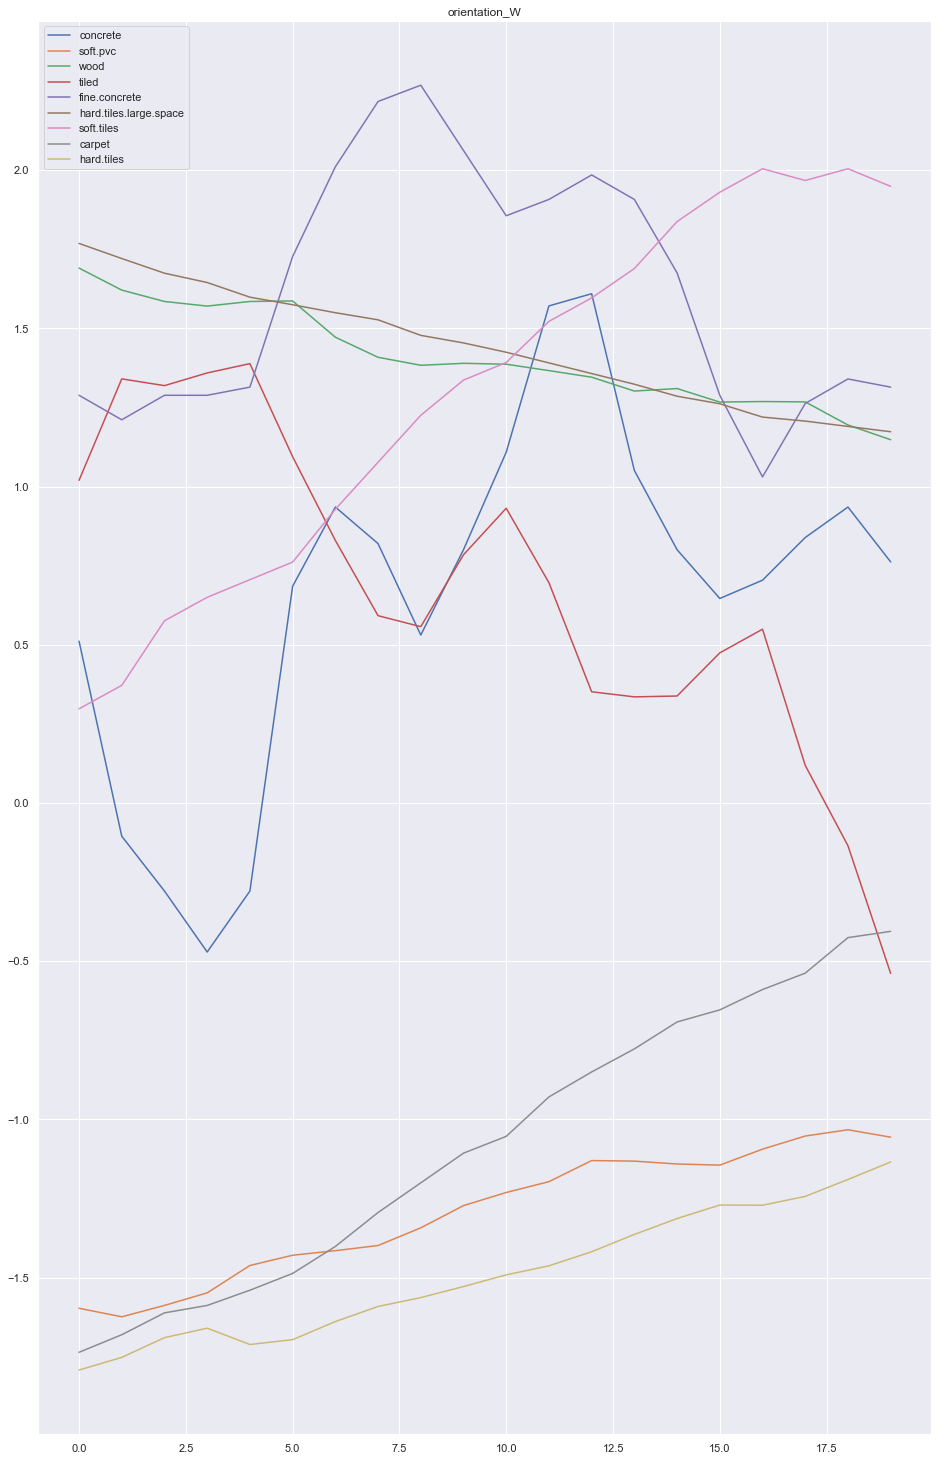

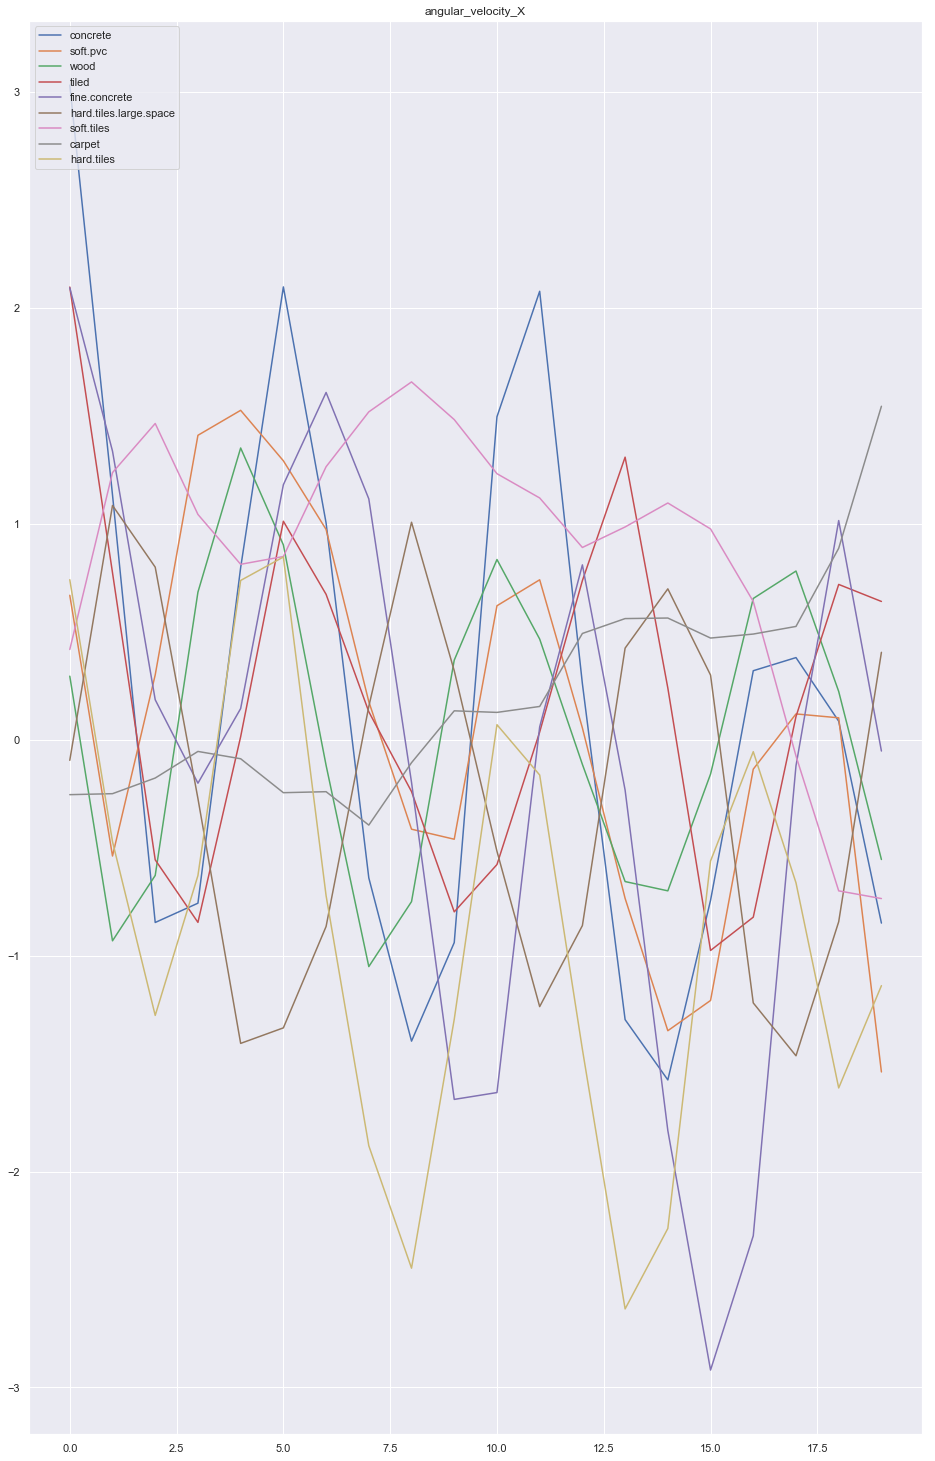

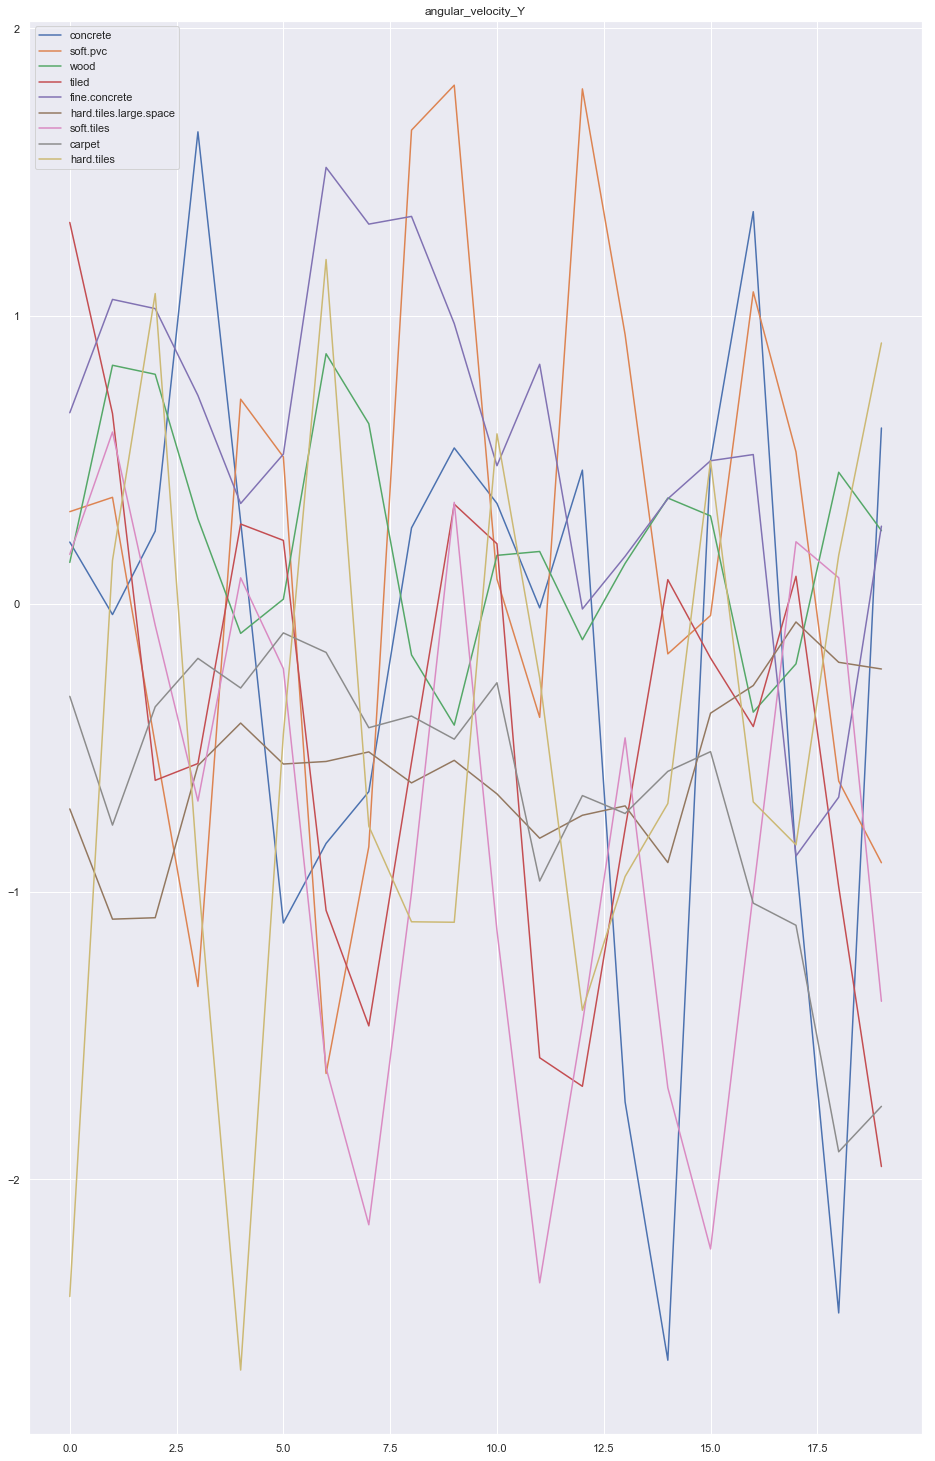

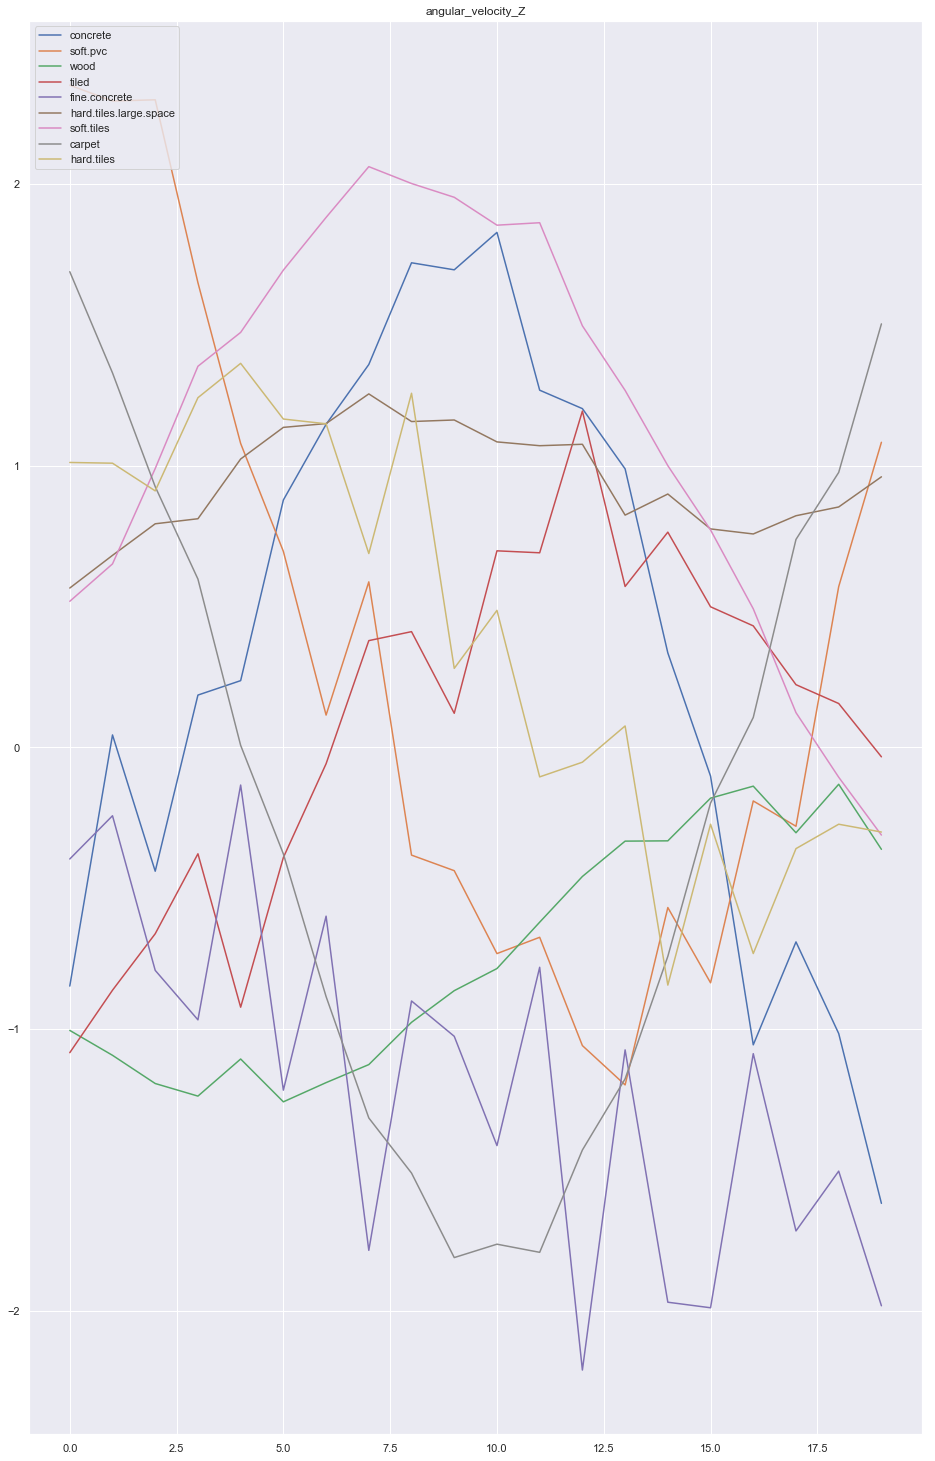

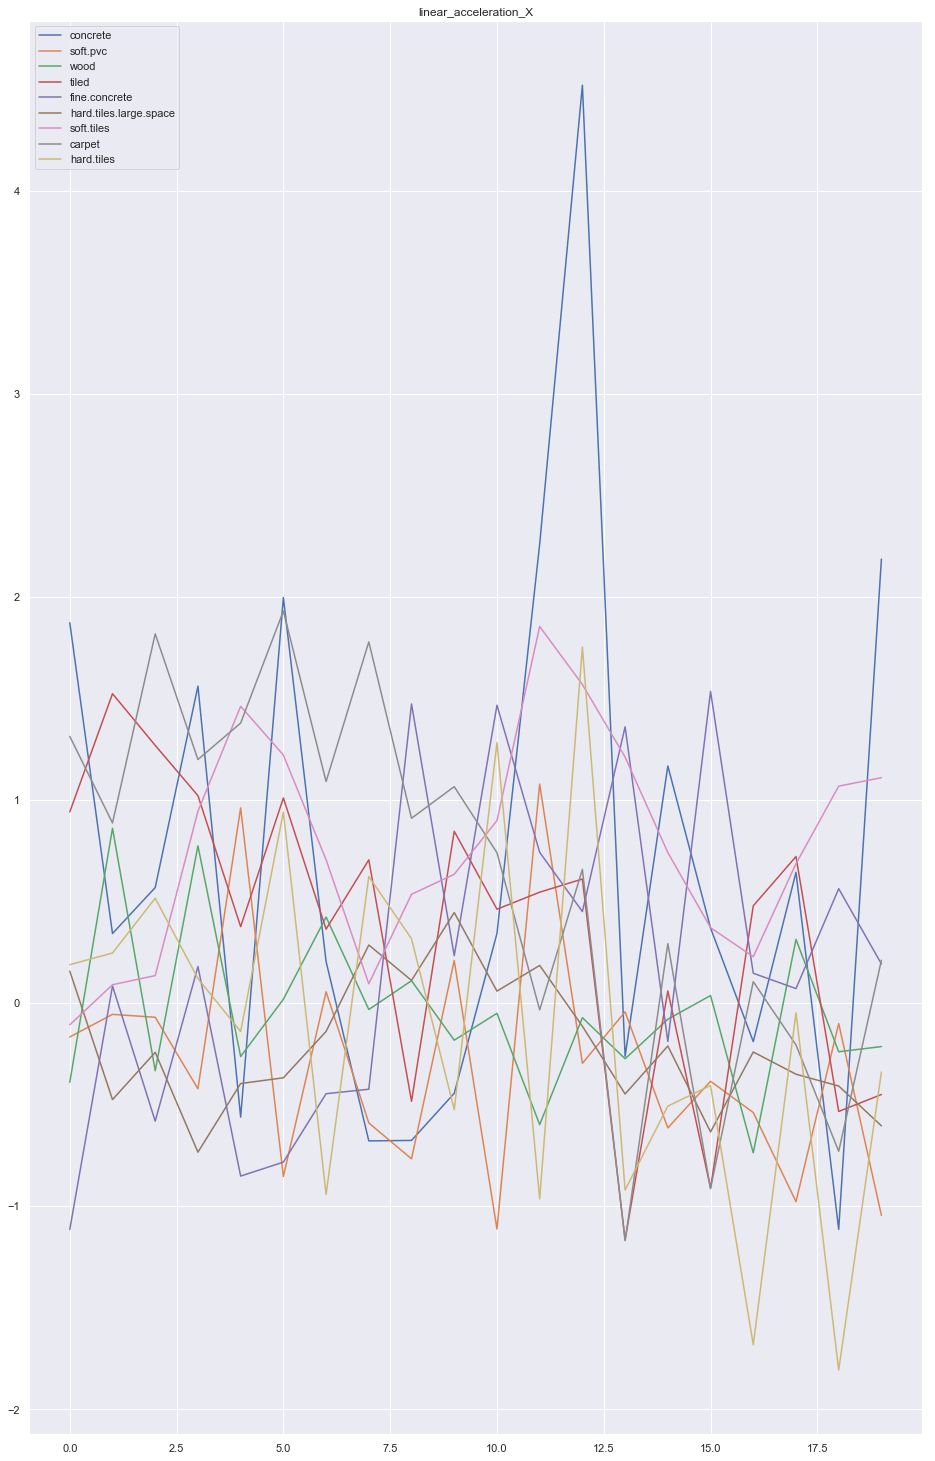

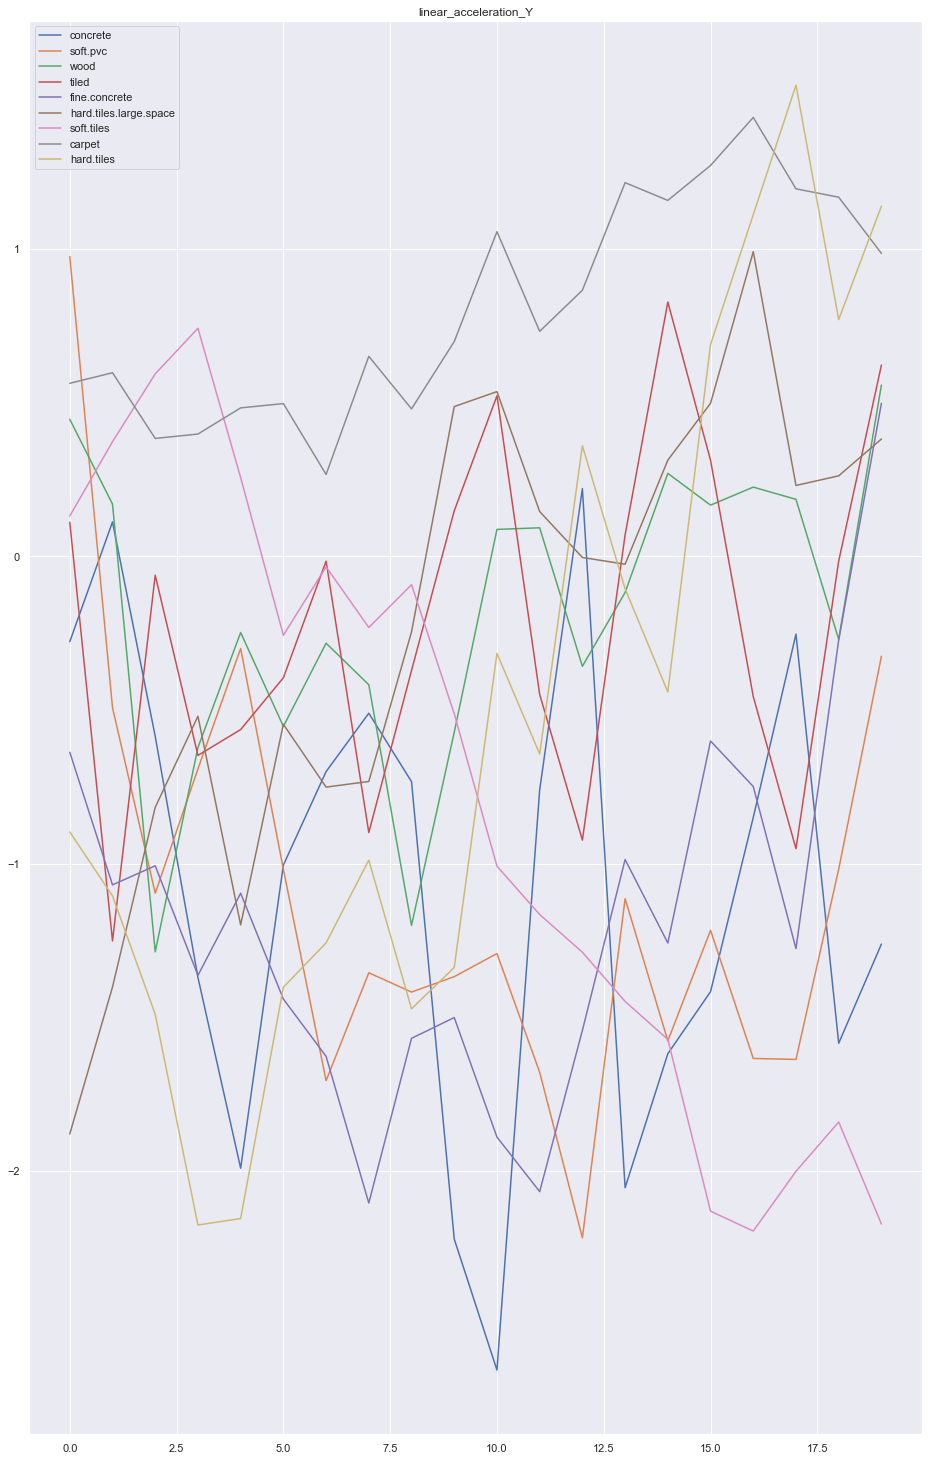

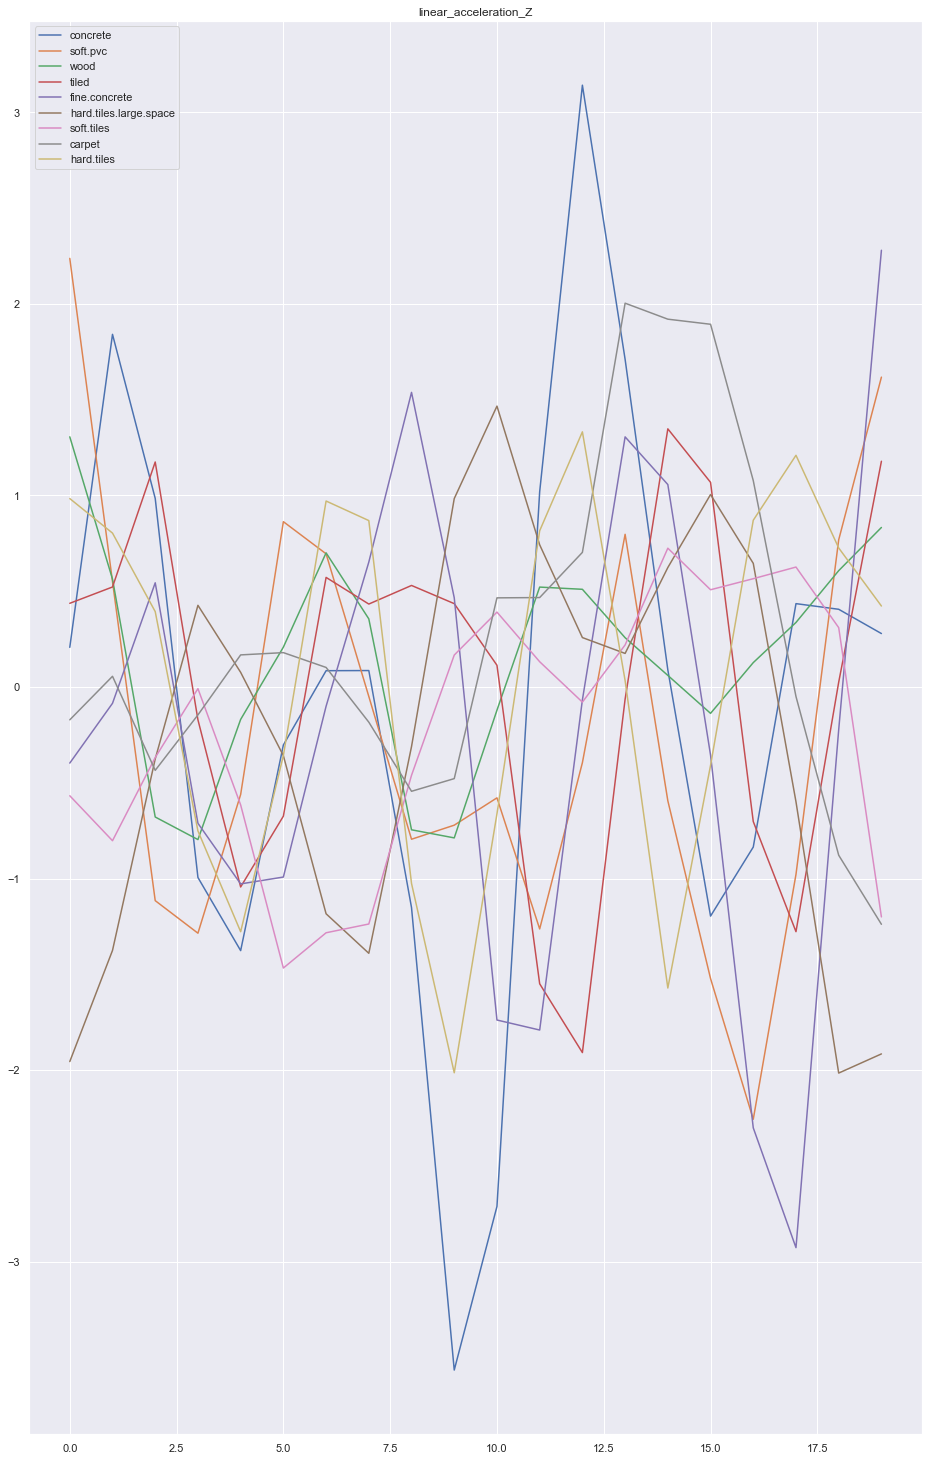

In [161]:
#plot data to see time series
#print(a[0,0:128,0])
time_order = [x for x in range(20)]
y_example_surface = [1,6,41,5, 0, 8,4,12,27]
y_labels = list(y_train['surface'].value_counts().index)
y_labels = [y_label.replace('_','.') for y_label in y_labels]

count = -1
for j in range(10):
    plt.figure(figsize=[16,26])
    plt.title(col[j+3])
    for i in y_example_surface:
        if i == 1:
            count = -1
        plt.plot(time_order,a[i,:20,j])
        count += 1
    plt.legend(y_labels,loc='upper left')


## Plot Power Spectrum Distribution (PSD) for each feature
Recurring patterns seen in the time-domain can be represented in the frequency domain using Fast Fourier Transform (FFT). Taking the squared of this result, we obtain the Power Spectrum Density (PSD) distribution for each time series.

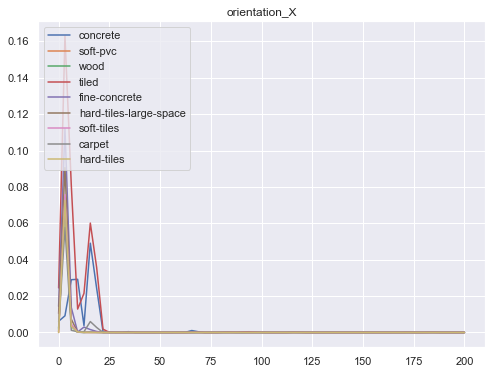

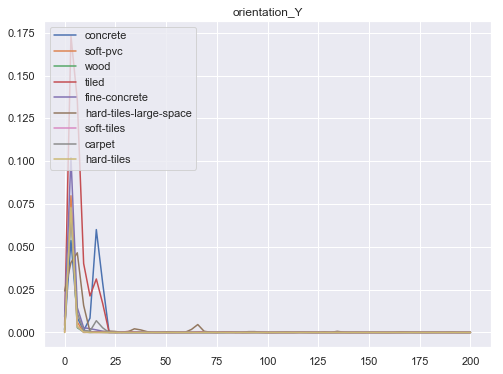

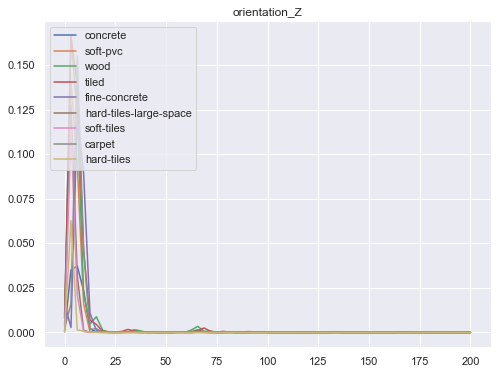

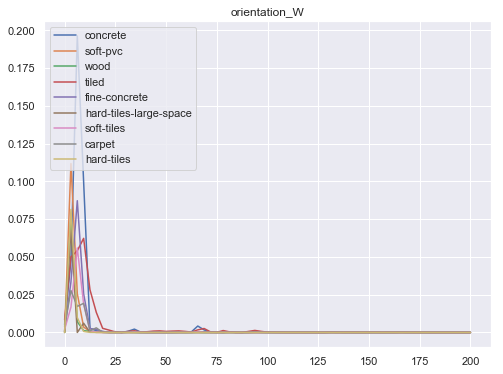

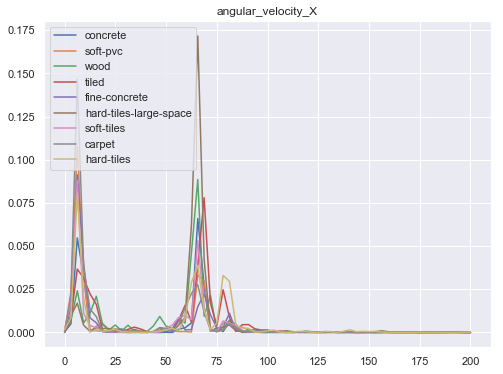

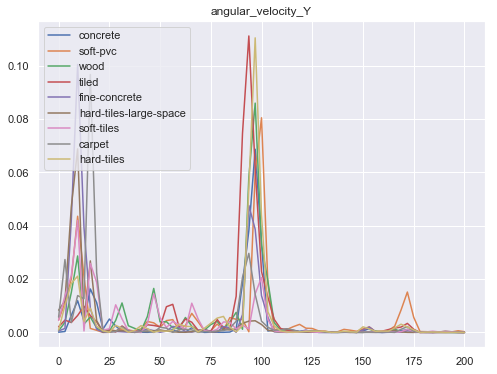

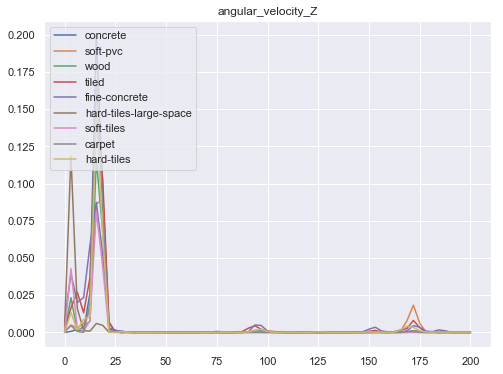

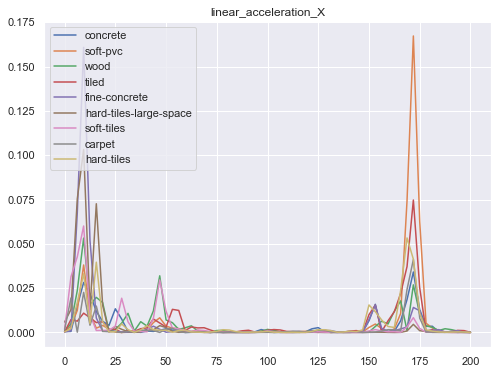

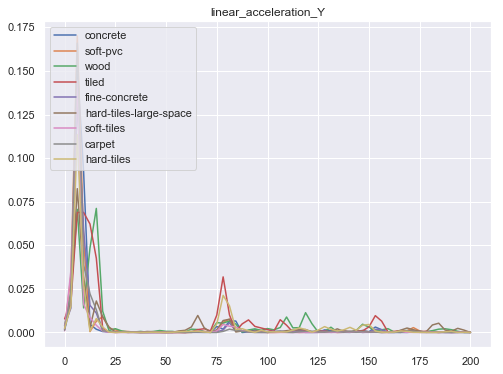

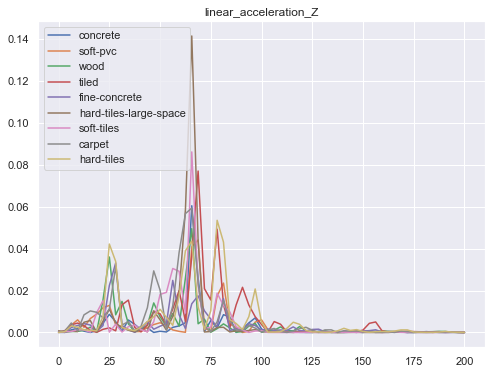

In [150]:
# explore statistical features
#plot data to see time series
#print(a[0,0:128,0])
time_order = [x for x in range(20)]
y_example_surface = [1,6,41,5, 0, 8,4,12,27]
y_labels = list(y_train['surface'].value_counts().index)
y_labels = [y_label.replace('_','-') for y_label in y_labels]

count = -1
for j in range(10):
    plt.figure(figsize=(8,6))
    plt.title(col[j+3])
    for i in y_example_surface:
        if i == 1:
            count = -1
        psd = welch(a[i,:,j],fs=400)
        plt.plot(psd[0],psd[1])
        count += 1
        
    plt.legend(y_labels,loc='upper left')

## Correlation Matrix between features
We can obtain correlations between features on the time-domain. This tells us how similar the time series of 2 features are. For instance, it appears that angular velocity X & Y are closely related (0.76).

Text(0.5, 1.0, 'X_train Features Correlation Heat Map')

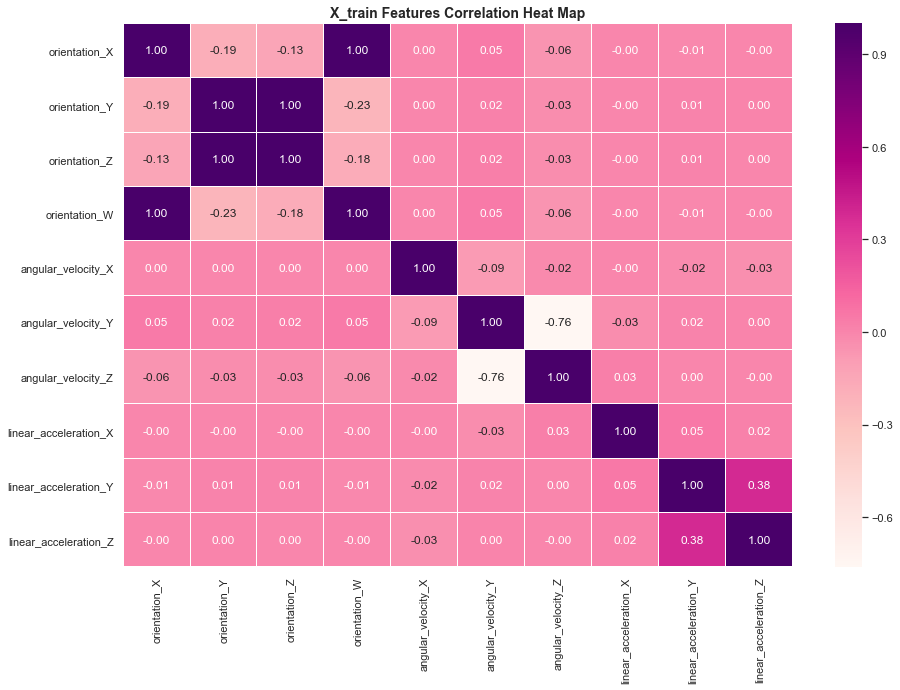

In [151]:
corr = X_train.corr()
corr

figure, axes = plt.subplots(1,1, figsize = (15,10))

heatmap = sns.heatmap(X_train.iloc[:,3:].corr(), ax = axes, cmap = 'RdPu', annot = True, fmt = '.2f', linewidths = 0.01)
heatmap.set_title('X_train Features Correlation Heat Map', fontsize=14, fontweight='bold')

## Kernel Density Estimate

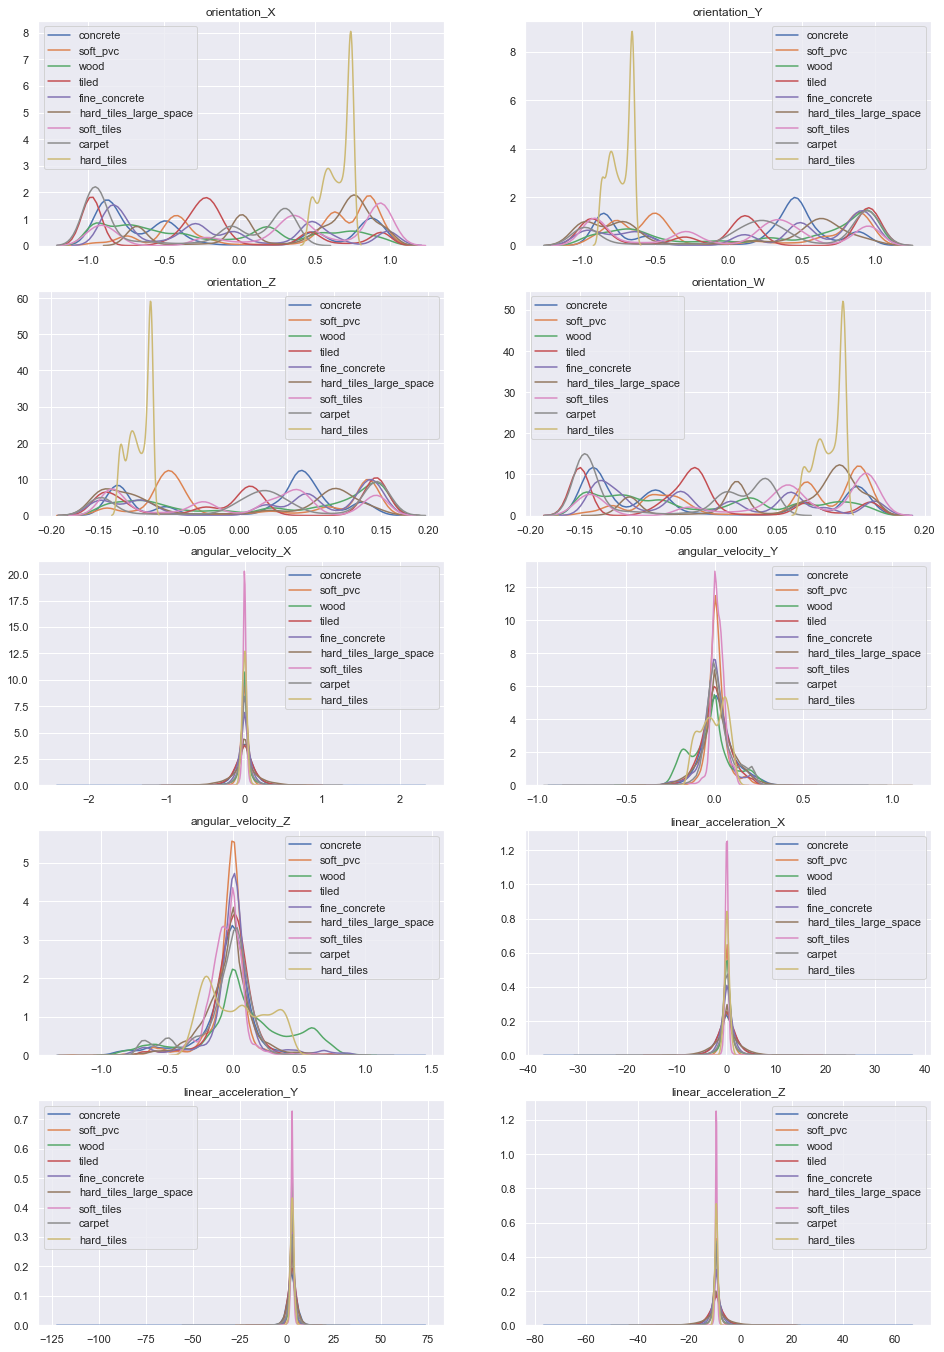

In [166]:
tmp = X_train.merge(y_train, on = 'series_id', how = 'inner')
y_labels = list(y_train['surface'].value_counts().index)

plt.figure(figsize=(16, 24))
for index,column in enumerate(X_train.columns[3:13]):
    plt.subplot(5,2,index+1)
    plt.title(column)
    for surface in y_labels:
        surface_feature = tmp[tmp['surface'] == surface]
        sns.kdeplot(surface_feature[column], label = surface)
